In [2]:
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.gaussian_process import *
from sklearn import preprocessing
from IPython.display import display

## Load and preprocess single day df

In [3]:
df = pd.read_csv('data/AIS_2024_01_01.csv')

# Preprocessing (ignore defaults from https://www.navcen.uscg.gov/ais-class-a-reports)
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])
df = df.sort_values(by=['MMSI', 'BaseDateTime'])
df = df[df['COG'] != 360]
df = df[df['SOG'] != 102.3]
df = df[df['LAT'] != 181]
df = df[df['Heading'] != 511]
df = df.dropna()

# Get unique MMSIs
MMSIs = df['MMSI'].unique()
print(f"Number of unique MMSIs: {len(MMSIs)}")


Number of unique MMSIs: 3453


In [4]:
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
15263,3660489,2024-01-01 00:01:47,27.37022,-89.92420,0.0,311.0,0.0,NEPTUNE TLP,IMO0745081,WQGV318,99.0,5.0,89.0,60.0,25.5,99.0,A
28831,3660489,2024-01-01 00:04:47,27.37020,-89.92420,0.0,311.0,0.0,NEPTUNE TLP,IMO0745081,WQGV318,99.0,5.0,89.0,60.0,25.5,99.0,A
50470,3660489,2024-01-01 00:07:47,27.37020,-89.92423,0.0,311.0,0.0,NEPTUNE TLP,IMO0745081,WQGV318,99.0,5.0,89.0,60.0,25.5,99.0,A
91449,3660489,2024-01-01 00:19:44,27.37032,-89.92430,0.0,273.0,0.0,NEPTUNE TLP,IMO0745081,WQGV318,99.0,5.0,89.0,60.0,25.5,99.0,A
538910,3660489,2024-01-01 00:28:44,27.37018,-89.92418,0.0,273.0,0.0,NEPTUNE TLP,IMO0745081,WQGV318,99.0,5.0,89.0,60.0,25.5,99.0,A


In [5]:
# Prints stats
print(f"Number of unique MMSIs: {len(MMSIs)}")
print(f"Total number of rows: {len(df)}")

Number of unique MMSIs: 3453
Total number of rows: 2128288


For each MMSI, compute the seconds since the start of the trajectory

In [6]:
# Dictionary to store MMSI stats
mmsi_stats = {}


for MMSI in tqdm(MMSIs, desc="Formatting dataset into trajectories"):
    single_ship_df = df[df['MMSI'] == MMSI]
    single_ship_df = single_ship_df.sort_values(by='BaseDateTime')
    single_ship_df = single_ship_df.drop_duplicates(subset=['BaseDateTime'], keep='last')
    
    # Compute seconds since start
    earliest_time = single_ship_df['BaseDateTime'].min()
    single_ship_df.head()
    single_ship_df['SecondsSinceStart'] = (single_ship_df['BaseDateTime'] - earliest_time).dt.total_seconds()
    df.loc[single_ship_df.index, 'SecondsSinceStart'] = single_ship_df['SecondsSinceStart']

    # Apply StandardScaler on LON, LAT, and Heading
    scaler = preprocessing.StandardScaler()
    scaled_features = scaler.fit_transform(single_ship_df[['LON', 'LAT', 'Heading']])
    df.loc[single_ship_df.index, ['Scaled_LON', 'Scaled_LAT', 'Scaled_Heading']] = scaled_features

    # Store mmsi stats
    mmsi_stats[MMSI] = {
        'EarliestTime': earliest_time,
        'LastTime': single_ship_df['BaseDateTime'].max(),
        'TotalDuration': (single_ship_df['BaseDateTime'].max() - earliest_time).total_seconds(),
        'NumRecords': len(single_ship_df),
    }

single_ship_df.head()


Formatting dataset into trajectories: 100%|██████████| 3453/3453 [00:16<00:00, 209.43it/s]


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,...,Status,Length,Width,Draft,Cargo,TransceiverClass,SecondsSinceStart,Scaled_LON,Scaled_LAT,Scaled_Heading
6623886,856583816,2024-01-01 06:39:01,41.14585,-71.74343,11.7,206.3,199.0,CT PILOT_US,IMO1245184,WTE9495,...,0.0,42.0,0.0,0.0,0.0,A,0.0,NaN,NaN,NaN
2156147,856583816,2024-01-01 06:49:50,41.11886,-71.76982,11.1,207.8,212.0,CT PILOT_US,IMO1245184,WTE9495,...,0.0,42.0,0.0,0.0,0.0,A,649.0,NaN,NaN,NaN
1815561,856583816,2024-01-01 06:53:01,41.11054,-71.77662,11.0,218.1,218.0,CT PILOT_US,IMO1245184,WTE9495,...,0.0,42.0,0.0,0.0,0.0,A,840.0,NaN,NaN,NaN
1828330,856583816,2024-01-01 06:56:47,41.10090,-71.77897,10.8,208.4,203.0,CT PILOT_US,IMO1245184,WTE9495,...,0.0,42.0,0.0,0.0,0.0,A,1066.0,NaN,NaN,NaN
2215943,856583816,2024-01-01 06:58:20,41.09647,-71.78163,10.9,201.8,202.0,CT PILOT_US,IMO1245184,WTE9495,...,0.0,42.0,0.0,0.0,0.0,A,1159.0,NaN,NaN,NaN


In [7]:
# Find the MMSI with the second most records
mmsi_stats
sorted_mmsi_stats = sorted(mmsi_stats.items(), key=lambda x: x[1]['NumRecords'], reverse=True)
# max_records_mmsi = max(mmsi_stats, key=lambda k: mmsi_stats[k]['NumRecords'])
# max_records_mmsi
sorted_mmsi_stats[0]

(np.int64(366921510),
 {'EarliestTime': Timestamp('2024-01-01 00:00:00'),
  'LastTime': Timestamp('2024-01-01 23:59:09'),
  'TotalDuration': 86349.0,
  'NumRecords': 1386})

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,...,Status,Length,Width,Draft,Cargo,TransceiverClass,SecondsSinceStart,Scaled_LON,Scaled_LAT,Scaled_Heading
6377618,366921510,2024-01-01 23:55:03,37.28890,-122.99620,7.0,342.2,344.0,SUN SPIRIT,IMO9085821,WDM6450,...,11.0,37.0,10.0,0.0,31.0,A,86103.0,-1.398033,1.648289,1.944733
7280622,366921510,2024-01-01 23:56:04,37.29075,-122.99683,6.8,339.7,343.0,SUN SPIRIT,IMO9085821,WDM6450,...,11.0,37.0,10.0,0.0,31.0,A,86164.0,-1.399040,1.650571,1.812222
7283350,366921510,2024-01-01 23:57:05,37.29263,-122.99750,7.0,344.5,346.0,SUN SPIRIT,IMO9085821,WDM6450,...,11.0,37.0,10.0,0.0,31.0,A,86225.0,-1.400112,1.652891,2.209754
6380825,366921510,2024-01-01 23:58:07,37.29444,-122.99811,7.0,346.1,345.0,SUN SPIRIT,IMO9085821,WDM6450,...,11.0,37.0,10.0,0.0,31.0,A,86287.0,-1.401087,1.655124,2.077243
6380909,366921510,2024-01-01 23:59:09,37.29637,-122.99881,6.7,342.7,343.0,SUN SPIRIT,IMO9085821,WDM6450,...,11.0,37.0,10.0,0.0,31.0,A,86349.0,-1.402206,1.657504,1.812222


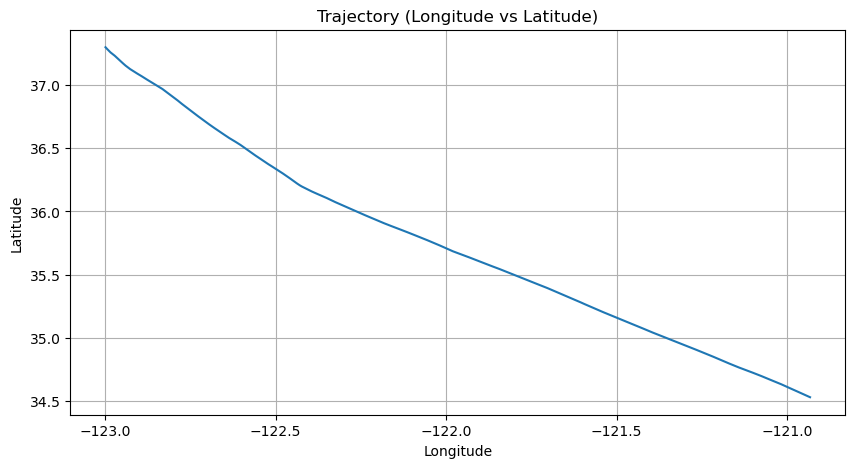

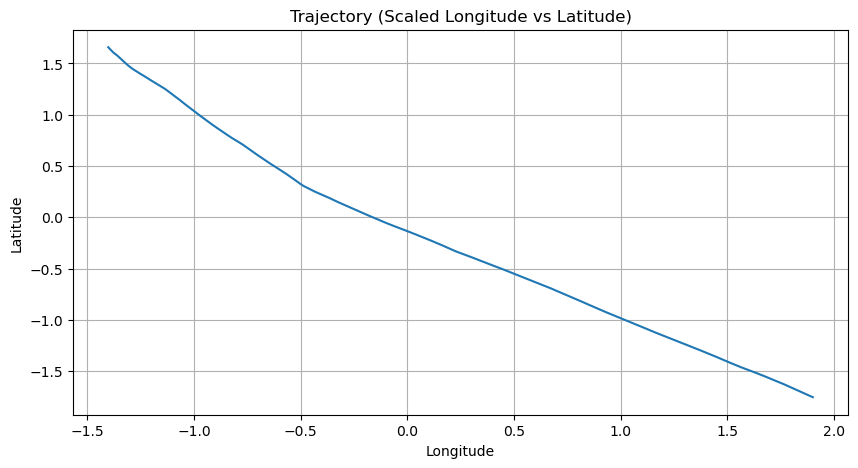

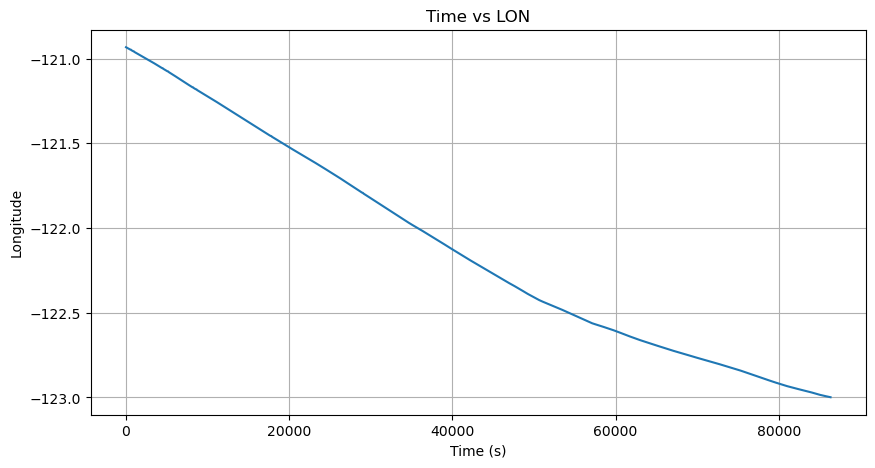

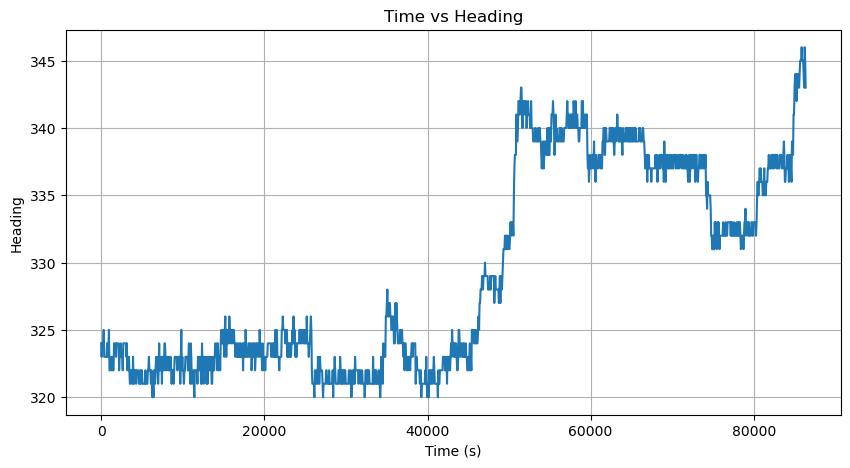

In [8]:
single_ship_df = df[df['MMSI'] == sorted_mmsi_stats[0][0]]
# single_ship_df = single_ship_df.dropna()
display(single_ship_df.tail())



# Plot Longitude vs Latitude
plt.figure(figsize=(10, 5))
plt.plot(single_ship_df['LON'], single_ship_df['LAT'], label='Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trajectory (Longitude vs Latitude)')
plt.grid()
plt.show()

# Plot Scaled Longitude vs Latitude
plt.figure(figsize=(10, 5))
plt.plot(single_ship_df['Scaled_LON'], single_ship_df['Scaled_LAT'], label='Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trajectory (Scaled Longitude vs Latitude)')
plt.grid()
plt.show()

# Plot Time vs LON
plt.figure(figsize=(10, 5))
plt.plot(single_ship_df['SecondsSinceStart'], single_ship_df['LON'])
plt.xlabel('Time (s)')
plt.ylabel('Longitude')
plt.title('Time vs LON')
plt.grid()
plt.show()

# Plot Time vs Heading
plt.figure(figsize=(10, 5))
plt.plot(single_ship_df['SecondsSinceStart'], single_ship_df['Heading'])
plt.xlabel('Time (s)')
plt.ylabel('Heading')
plt.title('Time vs Heading')
plt.grid()
plt.show()


In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
import time
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)

gp = GaussianProcessRegressor(kernel=kernel)


# GP fit
start_time = time.time()
gp.fit(single_ship_df[['SecondsSinceStart']], single_ship_df[['Scaled_LON']])
print(f"GP fit time: {time.time() - start_time:.2f} seconds")
print(f"GP kernel: {gp.kernel_}")


# GRP predict
start_time = time.time()
mean_predictions_gpr, std_predictions_gpr = gp.predict(single_ship_df[['SecondsSinceStart']], return_std=True)
print(f"GP predict time: {time.time() - start_time:.2f} seconds")

GP fit time: 0.27 seconds
GP kernel: RBF(length_scale=1) + WhiteKernel(noise_level=1e-05)
GP predict time: 0.06 seconds


/home/daniel/miniconda3/envs/ais/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
